In [1]:
#Import necessary packages:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from scipy.sparse import csr_matrix

In [2]:
#Loading .csv file to Pandas dataframe
df= pd.read_csv('reviews.csv')

In [3]:
#Protecting original data for future requirements
data= pd.read_csv('reviews.csv')

In [4]:
#Exploring the data information:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551682 entries, 0 to 551681
Data columns (total 2 columns):
overall       551682 non-null float64
reviewText    551466 non-null object
dtypes: float64(1), object(1)
memory usage: 8.4+ MB


In [5]:
#Exploring the data
df.head()

,overall,reviewText
0,5.0,My daughter wanted this book and the price on ...
1,5.0,I bought this zoku quick pop for my daughterr ...
2,4.0,There is no shortage of pop recipes available ...
3,5.0,This book is a must have if you get a Zoku (wh...
4,4.0,This cookbook is great. I have really enjoyed...


In [6]:
#Number of missing values in reviews
len(df[df['reviewText'].isnull()==True])

216

In [7]:
#Dropping the NaN's in reviews column
df=df.dropna(subset=['reviewText'])

In [8]:
#Adding length column to the dataset
df['review_length']= df['reviewText'].apply(len)

## Visualization of data

(0, 5000)

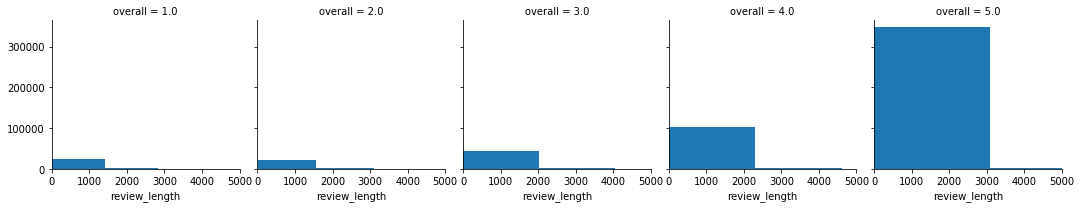

In [9]:
#Histogram grid plot
g = sns.FacetGrid(data=df, col='overall')
g.map(plt.hist, 'review_length')
plt.xlim(0,5000)

In [10]:
#Value counts of the overall rating
df['overall'].value_counts()

5.0    349572
4.0    105477
3.0     45043
1.0     27076
2.0     24298
Name: overall, dtype: int64

In [11]:
#Converting all the text to lowercase
df['reviewText']= df['reviewText'].str.lower()

In [12]:
# Str replace all non-alphanumeric whitespace
df["reviewText"] = df["reviewText"].str.replace('[^\w\s]','')

In [13]:
#Removing all the numeric values in the text
df["reviewText"] = df["reviewText"].str.replace('\d+', '')

In [14]:
#Tokenizing the text
df["reviewText"] = df["reviewText"].apply(word_tokenize) 

In [15]:
#Function to remove stops words
stop = stopwords.words('english')
def remove_stopwords(tokens):
    return([token for token in tokens if token not in stop])

In [16]:
#Applying function to remove stop words
df["reviewText"] = df["reviewText"].apply(lambda x: remove_stopwords(x)) 

In [17]:
# Instantiate and define the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    return([lemmatizer.lemmatize(token) for token in tokens])

In [18]:
#Lemmatizing the text
df['reviewText']=df['reviewText'].apply(lambda x: lemmatize(x))

In [19]:
#Creating a positive and negative review column for predictions
df['Positive_Negative']= [1 if x > 3 else 0 for x in df['overall']]

In [20]:
#Exploring the final data after text preprocessing
df.head()

,overall,reviewText,review_length,Positive_Negative
0,5.0,"[daughter, wanted, book, price, amazon, best, ...",158,1
1,5.0,"[bought, zoku, quick, pop, daughterr, zoku, qu...",125,1
2,4.0,"[shortage, pop, recipe, available, free, web, ...",2353,1
3,5.0,"[book, must, get, zoku, also, highly, recommen...",334,1
4,4.0,"[cookbook, great, really, enjoyed, reviewing, ...",538,1


In [21]:
#Splitting the data into train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.reviewText, df.Positive_Negative, random_state=0)

In [22]:
#Exploring the training and testing datasets
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (413599,)
y_train shape: (413599,)

x_test shape: (137867,)
y_test shape: (137867,)



In [23]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5, lowercase=False, tokenizer=lambda doc: doc).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<413599x43288 sparse matrix of type '<class 'numpy.int64'>'
	with 16079448 stored elements in Compressed Sparse Row format>


In [24]:
#Get feature names
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 43288


In [25]:
# Vectorize X_test
X_test = vectorizer.transform(x_test)
print("X_test:\n{}".format(repr(X_test)))

X_test:
<137867x43288 sparse matrix of type '<class 'numpy.int64'>'
	with 5356409 stored elements in Compressed Sparse Row format>


## Multinomial Bayes

In [26]:
#Building multinomial classifier
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [27]:
#Predictions on the test data
mnb_y_pred = mnb.predict(X_test)

In [28]:
#Accuracy score on the test data
mnb_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score))

Accuracy:   0.857


In [29]:
#Confusion matrix
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 13967   9752]
 [  9898 104250]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


In [30]:
#Classification report
print(classification_report(y_test, mnb_y_pred))

             precision    recall  f1-score   support

          0       0.59      0.59      0.59     23719
          1       0.91      0.91      0.91    114148

avg / total       0.86      0.86      0.86    137867



In [31]:
# Predictions count
Counter(mnb_y_pred)

Counter({1: 114002, 0: 23865})

## TfidfVectorizer

In [32]:
# Vectorize X_train
mnb_tfidfvectorizer = TfidfVectorizer(min_df=5, lowercase=False, tokenizer=lambda doc: doc).fit(x_train)
mnb_X_train = mnb_tfidfvectorizer.transform(x_train)
print("X_train:\n{}".format(repr(mnb_X_train)))

X_train:
<413599x43288 sparse matrix of type '<class 'numpy.float64'>'
	with 16079448 stored elements in Compressed Sparse Row format>


In [33]:
#Predictions on the test data
mnb_X_test = mnb_tfidfvectorizer.transform(x_test)
mnb_y_pred_1 = mnb.predict(mnb_X_test)

In [34]:
#Accuracy score on the test data
mnb_score2 = accuracy_score(y_test, mnb_y_pred_1)
print("Accuracy:   {:.3f}".format(mnb_score2))

Accuracy:   0.846


In [35]:
#Confusion matrix
mnb_cfm2 = confusion_matrix(y_test, mnb_y_pred_1)
print("Confusion matrix:")
print(mnb_cfm2, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[  2860  20859]
 [   419 113729]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


In [36]:
#Classification report
print(classification_report(y_test, mnb_y_pred_1))

             precision    recall  f1-score   support

          0       0.87      0.12      0.21     23719
          1       0.85      1.00      0.91    114148

avg / total       0.85      0.85      0.79    137867



In [37]:
# Predictions count
Counter(mnb_y_pred_1)

Counter({1: 134588, 0: 3279})

## Testing the predicted values with the actual data

In [38]:
# POSITIVE REVIEW
pr = data['reviewText'][355515]
print(pr)
print("Actual Rating:    ",data['overall'][355515])
pr_t = vectorizer.transform([x_train[355515]])
prediction= mnb.predict(pr_t)[0]
print("Predicted Rating: ", prediction)

In general, furniture gives me sticker shock, especially small tables like this. For $80, this is a bargain. The package arrived double-boxed and was in great shape. It took all of five minutes to put it together - the legs screw into the table top and it's ready...no need to mess around with putting the drawer together or installing glides. It's a dark cherry finish and looks great. There's no floor protectors and if you like to use the hard plastic nail-in kind, they won't work. The legs have pre-drilled holes but I'm not sure why. They're wide enough at the base to accommodate one-inch felt pads without spilling over and showing. All in all, a very nice value. For the price and fit/finish, it more than met my expectations.
Actual Rating:     5.0
Predicted Rating:  1


In [39]:
# POSITIVE REVIEW
pr = data['reviewText'][439887]
print(pr)
print("Actual Rating:    ",data['overall'][439887])
pr_t = vectorizer.transform([x_train[439887]])
prediction= mnb.predict(pr_t)[0]
print("Predicted Rating: ", prediction)

I needed to cover my UGLY apartment toilet.  This did the job quite well.  These are standard bathroom rugs and covers,  nothing fancy. And worth the price.
Actual Rating:     5.0
Predicted Rating:  1


In [40]:
# Negative REVIEW
pr = data['reviewText'][21]
print(pr)
print("Actual Rating:    ",data['overall'][21])
pr_t = vectorizer.transform([x_train[21]])
prediction= mnb.predict(pr_t)[0]
print("Predicted Rating: ", prediction)

So I actually bought this thinking it was the entire Lesson 2 kit. However, I've found through experience that having the book without having to take the class is a good thing. I've taken the Wilton Lesson 1 class and the number of Wilton items you have to purchase ALONG with the Lesson kit is a little ridiculous. I've worked my way through Lesson 1 and now I'm working my way (by myself) through lesson 2. I recommend anyone that likes to work on their own time to just purchase this book.
Actual Rating:     3.0
Predicted Rating:  0


In [41]:
# Negative REVIEW
pr = data['reviewText'][977]
print(pr)
print("Actual Rating:    ",data['overall'][120])
pr_t = vectorizer.transform([x_train[120]])
prediction= mnb.predict(pr_t)[0]
print("Predicted Rating: ", prediction)

It's basically a small flooring polisher.  It beats doing it on your hands and knees but it's not meant for doing a whole house of hardwoods at one time.
Actual Rating:     1.0
Predicted Rating:  0
